In [3]:
%load_ext autoreload
%autoreload 2
from predict_np import predict_from_np
from shapley_fda import ShapleyFda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import MonomialBasis
from skfda.representation.grid import FDataGrid
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


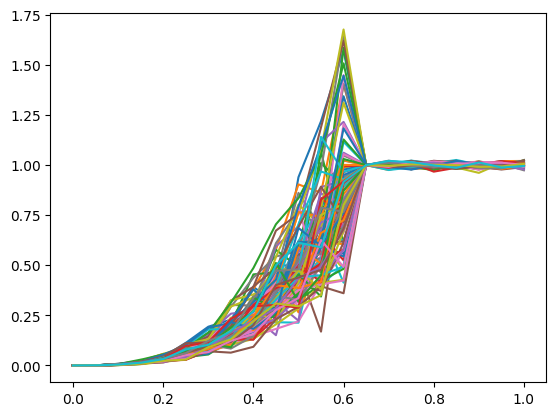

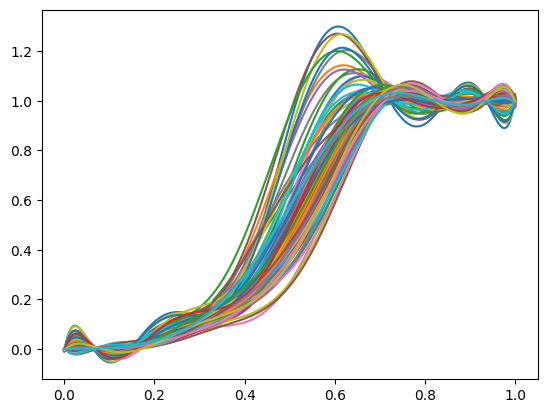

In [4]:
# Prepare the data
np.random.seed(1234)
num_functions = 100
rate_important_intervals = 0.7
basis = MonomialBasis(n_basis=10)
ini = 0
end = 1
domain_range = (ini, end)
step = 0.05
abscissa_points = np.arange(ini, end + step, step)
total_abscissa_points = abscissa_points.shape[0]
total_important_abcissa = int(np.floor(rate_important_intervals * abscissa_points.shape[0]))
vector_ones = np.full(shape=(num_functions, 1), fill_value=1)
vector_ones_abs = np.full(shape=(1, total_important_abcissa), fill_value=1)
vector_fun = np.array([x ** 3 for x in abscissa_points[:total_important_abcissa]], ndmin=2)
X_no_noise = np.dot(vector_ones, vector_fun) * (1 + np.random.normal(loc=0, scale=0.2, size=(num_functions, total_important_abcissa)))
X_last_abs = np.dot(np.reshape(X_no_noise[:, -1], newshape=(-1, 1)), vector_ones_abs)
X_no_noise = np.divide(X_no_noise, X_last_abs)
#X_no_noise = np.dot(vector_ones, vector_fun) + np.random.normal(loc=0, scale=0.001, size=(num_functions, total_important_abcissa))
X_last_abcissa = np.reshape(X_no_noise[:, -1], newshape=(-1, 1))
X_noise = np.random.normal(loc=X_last_abcissa, scale= 0.01, size=(num_functions, total_abscissa_points - total_important_abcissa))
y = np.empty(shape=num_functions)
for i in range(num_functions):
    y[i] = np.dot(X_no_noise[i, :], X_no_noise[i, :])
y = y - np.mean(y)
X = np.column_stack((X_no_noise, X_noise))
X_grid = FDataGrid(data_matrix=X, grid_points=abscissa_points, domain_range=domain_range)
X_basis = X_grid.to_basis(basis)
# Derivative
derivative_X = np.squeeze(X_basis.derivative().to_grid().data_matrix)
# Plot
zzz = X_grid.plot()
yyy = X_basis.plot()

In [5]:
# Fit the model
linear_reg = LinearRegression()
_ = linear_reg.fit(X_basis, y)

In [6]:
predict_function = predict_from_np(
    grid_points=abscissa_points,
    domain_range=domain_range,
    basis=basis,
    predict_fn = linear_reg.predict
)

In [7]:
y_pred = predict_function(X)

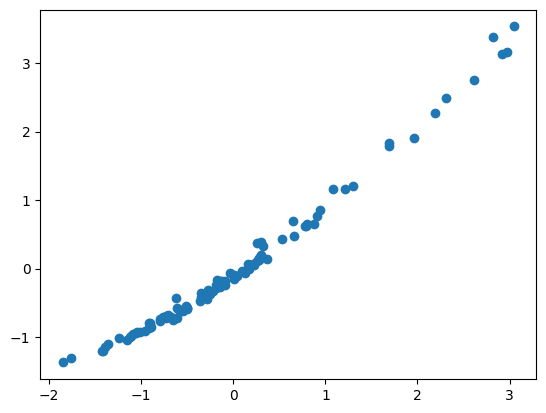

In [8]:
plt.scatter(y_pred, y)

In [9]:
shapley_fda = ShapleyFda(
    predict_fn=predict_function,
    X=X,
    derivate_X=derivative_X,
    abscissa_points=abscissa_points,
    target=y,
    domain_range=domain_range,
    verbose=True,
    debug=False,
)
values_shap = shapley_fda.compute_shapley_value(num_intervals=5, num_permutations=1)
#print("relevance:\n", values_shap, "\n")

 set_intervals:
 [[0.  0.2]
 [0.2 0.4]
 [0.4 0.6]
 [0.6 0.8]
 [0.8 1. ]]
 set_permutations: {(3, 0, 1, 2, 4)}
 abcissa: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]   abcissa_interval: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 4]
 Computing relevance for interval: [0.  0.2] whose index is 0
 	Permutation: (3, 0, 1, 2, 4)
 		use_interval: False 	available_intervals: [3] 	non_available_intervals: [0 1 2 4]
 			unique_intervals: [1 1 1 2]
 			label: 1
 				intervals: [0 1 2]
 				range ini: 0.0
 				range end: 0.6000000000000001
 				function: linear with abcissa: 0.6000000000000001
 			label: 2
 				intervals: [4]
 				range ini: 0.8
 				range end: 1.0
 				function: linear with abcissa: 0.8
 			recomputed_covariate: [[1.5714116210113995, 1.5714568264391346, 1.5715020318668698, 1.5715472372946047, 1.5715924427223398, 1.571637648150075, 1.57168285357781, 1.5717280590055451, 1.57177326443328, 1.5718184698610151, 1.5718636752887

In [10]:
print("relevance:\n", values_shap, "\n")

relevance:
 [[array([0. , 0.2]), 22985549.63491265], [array([0.2, 0.4]), 100.41537631795475], [array([0.4, 0.6]), 33.64546335047635], [array([0.6, 0.8]), -13917525.710031526], [array([0.8, 1. ]), -0.011776998976599451]] 

